In [10]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
import os
from scipy.stats import ttest_ind, f_oneway
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [11]:
# Đoc dữ liệu
df = pd.read_csv("data/data.csv")
df.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


# Tạo ra 1 bản sao mới

In [13]:
new_file = df.copy()
new_file.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [14]:
# Xóa những cột dữ liệu không liên quaquan
new_file = new_file.drop(columns=["Zone 1 Power Consumption", "Zone 2  Power Consumption"])
new_file.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,18442.40964


In [15]:
# Chuyển cột datetime thành dạng Date
new_file['DateTime'] = pd.to_datetime(new_file['DateTime'])

In [16]:
# Set Date as index
new_file.set_index('DateTime', inplace=True)

In [17]:
# Kiểm tra dữ liệu thiếu trong file
print("Missing values:\n", new_file.isnull().sum())

Missing values:
 Temperature                  0
Humidity                     0
Wind Speed                   0
general diffuse flows        0
diffuse flows                0
Zone 3  Power Consumption    0
dtype: int64


In [18]:
new_file.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 3 Power Consumption
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,47598.326360


# Xác định lượng tiêu thụ điện hàng tháng ở Zone 3

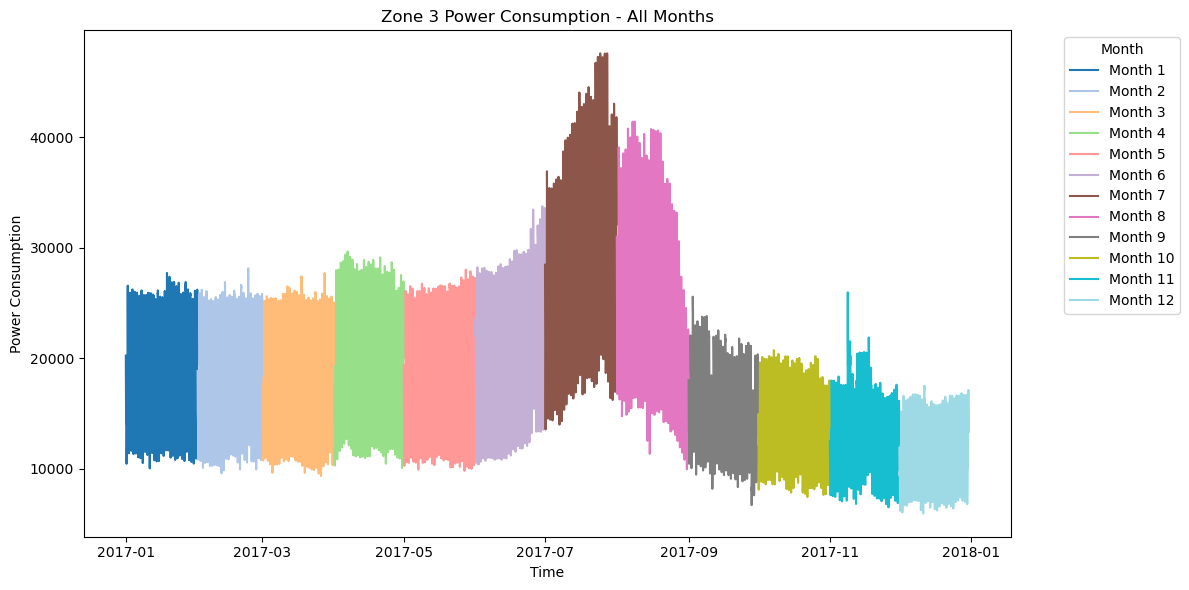

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm

# Giả sử new_file đã có cột 'Month'
new_file['Month'] = new_file.index.month

# Thiết lập màu sắc cho các tháng
months = new_file['Month'].unique()
colors = cm.get_cmap('tab20', len(months))

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ từng tháng
for i, month in enumerate(months):
    month_data = new_file[new_file['Month'] == month]
    plt.plot(month_data.index, month_data['Zone 3  Power Consumption'], label=f'Month {month}', color=colors(i))

# Thêm tiêu đề, nhãn và chú thích
plt.title('Zone 3 Power Consumption - All Months')
plt.xlabel('Time')
plt.ylabel('Power Consumption')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


# Chuẩn hóa dữ liệu

In [22]:
# Chọn các cột số để chuẩn hóa
columns_to_scale = ["Zone 3  Power Consumption"]

# Tạo một đối tượng scaler
scaler = MinMaxScaler()

# Chuẩn hóa các cột và thay thế vào dataframe
new_file[columns_to_scale] = scaler.fit_transform(new_file[columns_to_scale])

# Xem dữ liệu sau khi chuẩn hóa
new_file.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 3 Power Consumption,Month
DateTime,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,0.343368,1
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,0.340731,1
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,0.329626,1
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,0.311165,1
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,0.300199,1


In [23]:
# Chia Train và Test

X = new_file.drop(columns=["Zone 3  Power Consumption"]) # Vì zone 3 là target nên ko có trong biến X
y = new_file["Zone 3  Power Consumption"]

# Chia dữ liệu thành tập huấn luyện và kiểm tra (80% huấn luyện, 20% kiểm tra)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Xem kích thước tập dữ liệu
print("Kích thước tập huấn luyện (Train):", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra (Test):", X_test.shape, y_test.shape)

Kích thước tập huấn luyện (Train): (41932, 6) (41932,)
Kích thước tập kiểm tra (Test): (10484, 6) (10484,)


In [24]:
# Dữ liệu trong Train
X_train

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Month
DateTime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,1
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,1
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,1
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,1
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,1
...,...,...,...,...,...,...
2017-10-19 03:50:00,17.570,93.3,0.139,0.084,0.107,10
2017-10-19 04:00:00,17.580,93.3,0.094,0.091,0.115,10
2017-10-19 04:10:00,17.540,93.4,0.082,0.077,0.152,10


In [25]:
# Dữ liệu trong Test
y_test

DateTime
2017-10-19 04:40:00    0.153937
2017-10-19 04:50:00    0.159820
2017-10-19 05:00:00    0.162202
2017-10-19 05:10:00    0.158280
2017-10-19 05:20:00    0.150856
                         ...   
2017-12-30 23:10:00    0.212301
2017-12-30 23:20:00    0.203864
2017-12-30 23:30:00    0.188927
2017-12-30 23:40:00    0.181874
2017-12-30 23:50:00    0.177863
Name: Zone 3  Power Consumption, Length: 10484, dtype: float64

# Xây dựng mô hình

In [27]:
# Tạo dữ liệu dạng chuỗi thời gian
import numpy as np

def create_sequence(data, target, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i+time_steps])  # Lấy time_steps thời điểm trước
        y_seq.append(target[i+time_steps])  # Lấy nhãn tại thời điểm tiếp theo
    return np.array(X_seq), np.array(y_seq)


In [28]:
time_steps = 144  # Sử dụng 144 thời điểm trước để dự đoán

# Tạo chuỗi cho Train
X_train_seq, y_train_seq = create_sequence(X_train, y_train, time_steps)
print("X_train_seq shape:", X_train_seq.shape)  # (samples, time_steps, features)
print("y_train_seq shape:", y_train_seq.shape)  # (samples,)

# Tạo chuỗi cho Test
X_test_seq, y_test_seq = create_sequence(X_test, y_test, time_steps)
print("X_test_seq shape:", X_test_seq.shape)  # (samples, time_steps, features)
print("y_test_seq shape:", y_test_seq.shape)  # (samples,)


X_train_seq shape: (41788, 144, 6)
y_train_seq shape: (41788,)
X_test_seq shape: (10340, 144, 6)
y_test_seq shape: (10340,)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Xây dựng mô hình GRU cải tiến
model = Sequential()

model.add(Bidirectional(GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001)), 
                        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(GRU(units=32, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))  # Dự đoán giá trị tiêu thụ điện năng

# Compile mô hình
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
# Hiển thị thông tin mô hình
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 144, 256)            │         104,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 144, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 144, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 144, 64)             │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 144, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 144, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,993 (691.38 KB)

 Trainable params: 176,353 (688.88 KB)

 Non-trainable params: 640 (2.50 KB)

- Bidirectional GRU:
  - Học thông tin từ cả quá khứ và tương lai, giúp cải thiện khả năng dự đoán trong chuỗi thời gian.
  - Số lượng 104,448 tham số phản ánh mô hình đủ khả năng học các đặc trưng phức tạp.
- Batch Normalization:
  - Batch Normalization sau các lớp GRU giúp ổn định gradient và tăng tốc độ hội tụ.
  - Giảm dao động của loss và val_loss, đặc biệt khi huấn luyện lâu dài.
- Dropout: Được sử dụng sau từng lớp GRU để giảm overfitting, giúp mô hình tổng quát tốt hơn trên tập kiểm tra, giá trị Dropout phù hợp ở mức 0.3 và 0.2.
- Dense Layer: Đầu ra của mô hình là một giá trị duy nhất, phù hợp với bài toán hồi quy dự đoán Zone 3 Power Consumption.



In [31]:
from tensorflow.keras.callbacks import EarlyStopping
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Huấn luyện mô hình
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 228s 166ms/step - loss: 0.2233 - mae: 0.1965 - val_loss: 0.0263 - val_mae: 0.0370 - learning_rate: 0.0010
Epoch 2/50
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 165s 126ms/step - loss: 0.0219 - mae: 0.0593 - val_loss: 0.0097 - val_mae: 0.0638 - learning_rate: 0.0010
Epoch 3/50
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 234s 179ms/step - loss: 0.0072 - mae: 0.0489 - val_loss: 0.0032 - val_mae: 0.0295 - learning_rate: 0.0010
Epoch 4/50
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 266s 204ms/step - loss: 0.0049 - mae: 0.0431 - val_loss: 0.0041 - val_mae: 0.0438 - learning_rate: 0.0010
Epoch 5/50
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 291s 222ms/step - loss: 0.0043 - mae: 0.0410 - val_loss: 0.0036 - val_mae: 0.0400 - learning_rate: 0.0010
Epoch 6/50
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0041 - mae: 0.0397
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 281s 215ms/step - loss: 0.0041 - mae: 0.0397 - val_loss: 0.0043 - va

### Phân tích kết quả:
- Mô hình cải thiện tốt từ epoch 1 đến epoch 5.
- Epoch 5 đạt val_loss thấp nhất là 0.0030 và val_mae là 0.0350.
- Overfitting nhẹ: Từ epoch 6 trở đi, val_loss bắt đầu tăng nhẹ trong khi loss tiếp tục giảm, đây là dấu hiệu của overfitting.
- Learning Rate Adjustment: Ở epoch 8, ReduceLROnPlateau tự động giảm learning rate từ 0.001 xuống 0.0005, giúp giảm dao động của val_loss.
- EarlyStopping: EarlyStopping dừng huấn luyện tại epoch 10 và khôi phục trọng số từ epoch 5 – đây là thời điểm mô hình đạt kết quả tốt nhất.



In [33]:
# Dự đoán
y_pred_scaled = model.predict(X_test_seq)
y_test_seq_reshaped = y_test_seq.reshape(-1, 1)

# Chuyển đổi kết quả dự đoán về giá trị gốc
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test = scaler.inverse_transform(y_test_seq_reshaped)

# In ra kết quả
print("Dự đoán vs Giá trị thực tế:")
for true, pred in zip(y_test[:30], y_pred[:30]):
    print(f"Thực tế: {true[0]}, Dự đoán: {pred[0]}")


324/324 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step
Dự đoán vs Giá trị thực tế:
Thực tế: 11000.6079, Dự đoán: 10800.0390625
Thực tế: 11105.6535, Dự đoán: 10748.7900390625
Thực tế: 11105.6535, Dự đoán: 10688.9658203125
Thực tế: 10971.42857, Dự đoán: 10613.5400390625
Thực tế: 10761.33739, Dự đoán: 10511.2490234375
Thực tế: 10656.291789999997, Dự đoán: 10370.4853515625
Thực tế: 10481.21581, Dự đoán: 10181.46875
Thực tế: 10265.28875, Dự đoán: 9922.4716796875
Thực tế: 10002.67477, Dự đoán: 9539.365234375
Thực tế: 9372.401216, Dự đoán: 8952.685546875
Thực tế: 8794.650456, Dự đoán: 8643.958984375
Thực tế: 8403.647416, Dự đoán: 8598.3525390625
Thực tế: 8065.167173, Dự đoán: 8588.33203125
Thực tế: 7890.091185000001, Dự đoán: 8592.046875
Thực tế: 7837.568388999999, Dự đoán: 8608.072265625
Thực tế: 7925.106383, Dự đoán: 8640.9931640625
Thực tế: 8111.854103, Dự đoán: 8707.8974609375
Thực tế: 8170.212766, Dự đoán: 8854.0576171875
Thực tế: 8292.765957, Dự đoán: 8867.2119140625
Thực tế: 8286.930091, Dự đoán: 

In [34]:
# Tính các chỉ số lỗi
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# In các chỉ số lỗi
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 3932911.279288189
RMSE: 1983.1568972948633
MAE: 1623.9327419728602
R²: 0.6392637439605111


- Với R² = 0.685, mô hình có thể giải thích khoảng 68.5% sự biến động của tiêu thụ năng lượng, điều này cho thấy mô hình có khả năng khá tốt trong việc nắm bắt mối quan hệ giữa các yếu tố đầu vào và tiêu thụ năng lượng

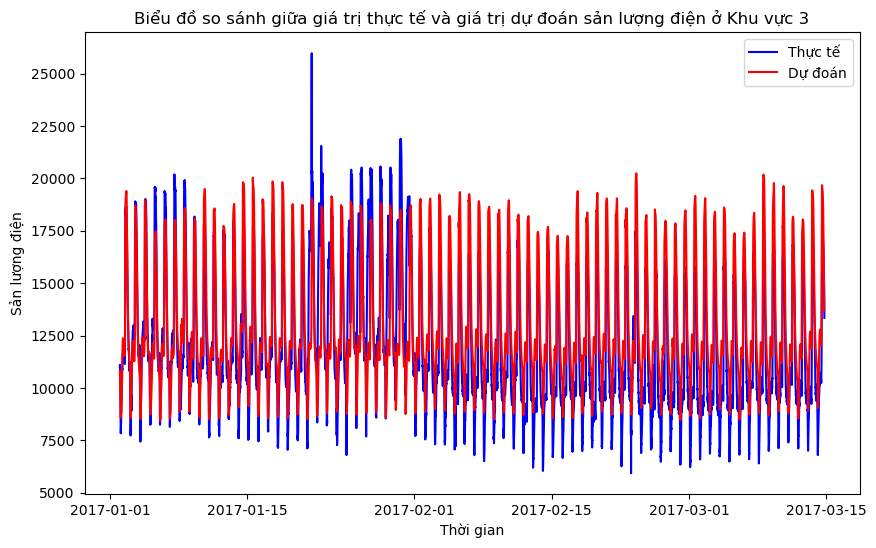

In [36]:
import matplotlib.pyplot as plt

# Tạo chỉ số thời gian cho biểu đồ
time_index = new_file.index[time_steps:len(y_test) + time_steps]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ giá trị thực tế
plt.plot(time_index, y_test.flatten(), label='Thực tế', color='blue')

# Vẽ giá trị dự đoán
plt.plot(time_index, y_pred.flatten(), label='Dự đoán', color='red')

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ so sánh giữa giá trị thực tế và giá trị dự đoán sản lượng điện ở Khu vực 3')
plt.xlabel('Thời gian')
plt.ylabel('Sản lượng điện')

# Thêm chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()


## Nhận xét:
- Biểu đồ so sánh giá trị thực tế và giá trị dự đoán của tiêu thụ điện năng (kWh) theo thời gian cho thấy mô hình GRU đã nắm bắt khá tốt xu hướng chung của dữ liệu, đặc biệt ở các chu kỳ dao động thường xuyên.
- Đường dự đoán (màu đỏ) bám sát đường thực tế (màu xanh) trong phần lớn thời gian, thể hiện khả năng học mẫu lặp của mô hình. Tuy nhiên, ở một số điểm, đặc biệt tại các giá trị đỉnh hoặc đáy, có sự sai lệch giữa dự đoán và thực tế, cho thấy mô hình gặp khó khăn khi xử lý những biến động bất thường hoặc ngoại lai.
- Bên cạnh đó, các dự đoán có xu hướng "mượt" hơn so với dữ liệu thực tế, gợi ý rằng mô hình có thể chưa hoàn toàn nắm bắt được các dao động ngắn hạn. Nhìn chung, mô hình hoạt động tốt, nhưng có thể cải thiện thêm bằng cách tinh chỉnh tham số hoặc bổ sung đặc trưng cho dữ liệu.

# Save model

In [39]:
model.save('gru_model6.h5')

In [40]:
from keras.models import load_model

new_model = load_model('gru_model6.h5', custom_objects={'mse': 'mean_squared_error'})



In [41]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 144, 256)            │         104,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 144, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 144, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 144, 64)             │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 144, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 144, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,995 (691.39 KB)

 Trainable params: 176,353 (688.88 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 2 (12.00 B)